In [ ]:
import modin.pandas as pd

In [1]:
import pandas as pd

In [138]:
df_logons = pd.read_csv('logon.csv')

In [139]:
df_logons.columns

Index(['id', 'date', 'user', 'pc', 'activity'], dtype='object')

In [140]:
# number of user logins by pc
df_logons.groupby('pc')['user'].unique()

pc
PC-0015    [TKW0289, WSP0210, JVS0212, DWG0209, BLA0039, ...
PC-0027    [HDE0756, BLA0039, DWG0209, LEB0888, LUP0038, ...
PC-0042    [AMR0208, JVS0212, PAW0040, WSP0210, LUP0038, ...
PC-0051    [LXW0999, HKW0211, DWG0209, UAP0214, ZNS0213, ...
PC-0059    [GRM0263, WSP0210, UAP0214, ZNS0213, BLA0039, ...
                                 ...                        
PC-9961    [HRL0797, ZNS0213, LUP0038, DWG0209, JVS0212, ...
PC-9974    [WMH0866, BJE0520, UAP0214, DWG0209, HKW0211, ...
PC-9979                 [DZJ0261, PAW0040, BLA0039, JVS0212]
PC-9989    [LDF0262, DWG0209, HKW0211, LUP0038, UAP0214, ...
PC-9999    [JAW0007, DWG0209, WSP0210, PAW0040, CZB0191, ...
Name: user, Length: 953, dtype: object

In [141]:
# looking specifically at one, we see that one user principle uses this machine
df_logons[df_logons['pc'] == 'PC-0015']['user'].value_counts()

TKW0289    1198
JVS0212      10
DWG0209       4
ZNS0213       4
WSP0210       2
BLA0039       2
LUP0038       2
HKW0211       2
BJH0243       2
Name: user, dtype: int64

In [142]:
# the number of pcs in the environment
len(df_pclogons)

953

In [143]:
# types of activities
df_logons['activity'].unique()

array(['Logon', 'Logoff'], dtype=object)

In [144]:
df_logons['date']  = pd.to_datetime(df_logons['date'])

In [145]:
df_logons['dateHour'] = df_logons['date'].dt.hour

In [146]:
df_logons['dateDay'] = df_logons['date'].dt.day

In [9]:
# activities in total for all users all time.
df_logons.groupby('user').count()

,id,date,pc,activity,dateHour,dateDay
user,,,,,,
AAC0070,690,690,690,690,690,690
AAP0946,1185,1185,1185,1185,1185,1185
AAR0716,993,993,993,993,993,993
AAS0850,963,963,963,963,963,963
ABG0865,1680,1680,1680,1680,1680,1680
...,...,...,...,...,...,...
ZKC0722,690,690,690,690,690,690
ZLB0620,690,690,690,690,690,690
ZLW0169,690,690,690,690,690,690


In [147]:
df_logons['calendarDay'] = df_logons['date'].dt.date

In [148]:
df_hasLogon = df_logons[df_logons['activity'] == 'Logon'].groupby(['user', 'calendarDay']).count()['date'].reset_index()
df_hasLogon['dateString'] = df_hasLogon['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
df_hasLogon['userDate'] = df_hasLogon.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
df_hasLogon = df_hasLogon[['userDate','date']]
df_hasLogon

,userDate,date
0,AAC0070_20100104,1
1,AAC0070_20100105,1
2,AAC0070_20100106,1
3,AAC0070_20100107,1
4,AAC0070_20100108,1
...,...,...
339993,ZSP0972_20110509,1
339994,ZSP0972_20110510,1
339995,ZSP0972_20110511,1
339996,ZSP0972_20110512,1


In [87]:
df_hasLogon.rename(columns={'date':'count'}).to_pickle('hasLogins.pkl')

In [159]:
df_logons['dateString'] = df_logons['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
df_logons['userDate'] = df_logons.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
df_numPC = df_logons[df_logons['activity'] == 'Logon'].groupby('userDate')['pc'].count().to_frame().rename(columns={'pc':'countPC'})
df_numPC[df_numPC['countPC'] != 1]
df_numPC.to_pickle('numPC.pkl')

In [10]:
from sklearn.neighbors import KernelDensity

In [11]:
df_logons.groupby('dateHour').count()

,id,date,user,pc,activity,dateDay
dateHour,,,,,,
0,2369,2369,2369,2369,2369,2369
1,2489,2489,2489,2489,2489,2489
2,2629,2629,2629,2629,2629,2629
3,2667,2667,2667,2667,2667,2667
4,2709,2709,2709,2709,2709,2709
5,2919,2919,2919,2919,2919,2919
6,19706,19706,19706,19706,19706,19706
7,175917,175917,175917,175917,175917,175917
8,124665,124665,124665,124665,124665,124665


In [12]:
df_logons[df_logons['activity'] == 'Logon'].groupby('user')['dateHour'].value_counts().loc['AAC0070']


dateHour
7    345
Name: dateHour, dtype: int64

In [13]:
df_numLogonDate = df_logons[df_logons['activity'] == 'Logon'].groupby(['user','date']).count()

In [14]:
df_numLogonDate[df_numLogonDate['id'] > 1 ]

,,id,pc,activity,dateHour,dateDay
user,date,,,,,
BLA0039,2011-03-31 22:39:33,2,2,2,2,2
JVS0212,2010-10-27 20:42:34,2,2,2,2,2


In [15]:
df_ldap = pd.read_pickle('../ldap/ldap.pkl')

In [16]:
df_userRole = df_ldap[['user_id', 'role']].drop_duplicates()
df_userRole.rename(columns={'user_id':'user'}, inplace=True)

In [17]:
df_logonsRole = df_logons.merge(df_userRole, on='user')

In [18]:
df_logonsRole.groupby('role').value_counts(['dateHour'])

role           dateHour
Accountant     7           1079
               15          1058
               18           798
               9            749
               8            660
                           ... 
VicePresident  18           180
               11           178
               14           133
               10            72
               17            16
Length: 760, dtype: int64

<AxesSubplot: xlabel='dateHour'>

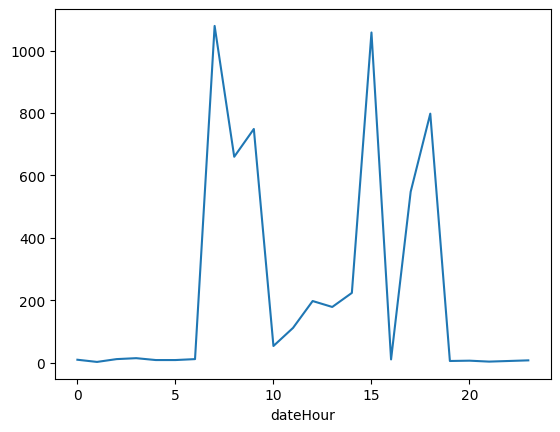

In [19]:
df_logonsRole.groupby('role').value_counts(['dateHour']).loc['Accountant'].sort_index().plot()

In [20]:
df_LoginAccountant = df_logonsRole[(df_logonsRole['role'] == 'Accountant') &
                                    (df_logonsRole['activity'] == 'Logon')]

In [21]:
df_LoginAccountant['dateHour'].array

<PandasArray>
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
 ...
 9, 8, 9, 8, 9, 9, 9, 9, 9, 8]
Length: 3256, dtype: int64

In [22]:
#kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginAccountant['dateHour'][:, np.newaxis])
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginAccountant['dateHour'].array.reshape(-1, 1))

In [34]:
import numpy as np

temp = []

for hour in range(0,24):
    density = np.exp(kde.score_samples([[hour]]))
    temp.append(density[0])

sum(temp)

0.9988239221553605

In [38]:
roleProbHour = {}


for role in df_logonsRole['role'].unique():
    
    df_LoginHour = df_logonsRole[(df_logonsRole['role'] == role) &
                                    (df_logonsRole['activity'] == 'Logon')]
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_LoginHour['dateHour'].array.reshape(-1, 1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    roleProbHour[role] = temp

    print(role, sum(temp.values()))
    

Mathematician 0.9996350173783236
LabManager 0.9991361037893735
Technician 0.9993294902006873
AdministrativeAssistant 0.9988440903471365
Salesman 0.9995039345979825
MechanicalEngineer 0.9994653684055954
Director 0.9993231385846802
MaterialsEngineer 0.9998942539362642
ComputerScientist 0.9995932718781607
ProductionLineWorker 0.9994609309247773
SoftwareEngineer 0.9998887251332971
SecurityGuard 1.0000000049342792
SystemsEngineer 0.9992634644635633
ComputerTrainer 0.9963289179294134
Physicist 0.9992988425377478
IndustrialEngineer 0.9998765613331123
ComputerProgrammer 0.9989127075532417
Scientist 0.9995157263736139
ChiefEngineer 1.0000000053484073
ElectricalEngineer 0.9993751330089448
PurchasingClerk 0.9998248720606783
Manager 0.9997497426118149
ITAdmin 0.9640549710297114
Statistician 0.9990456508722377
HealthSafetyEngineer 1.000000005344815
HumanResourceSpecialist 0.9994396286179551
TestEngineer 1.0000000053494003
Accountant 0.9988239221553605
VicePresident 1.0000000053445675
Administrative

In [92]:
df_roleProbHour = pd.DataFrame(roleProbHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]
df_roleProbHour.to_pickle('roleProbHour.pkl')

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Mathematician,0.000463,0.000582,0.000587,0.001821,0.017622,0.084227,0.176196,0.204167,0.173276,0.105800,...,0.030544,0.014124,0.005465,0.003065,0.001873,0.001086,0.000697,0.000528,0.000447,0.000273
LabManager,0.001162,0.001617,0.001703,0.002557,0.013382,0.060996,0.135168,0.166115,0.142230,0.097698,...,0.050557,0.024991,0.008523,0.003261,0.001760,0.001355,0.001101,0.000880,0.000749,0.000544
Technician,0.000665,0.000939,0.001026,0.001043,0.003004,0.027269,0.125051,0.235177,0.213485,0.131576,...,0.026311,0.011743,0.004274,0.002498,0.001976,0.001312,0.000963,0.000953,0.000908,0.000655
AdministrativeAssistant,0.001123,0.001613,0.001615,0.001594,0.003687,0.024729,0.106983,0.209620,0.202112,0.118775,...,0.034701,0.014460,0.005667,0.002722,0.001893,0.001615,0.001563,0.001505,0.001397,0.001119
Salesman,0.000437,0.000656,0.000744,0.001139,0.006895,0.045616,0.159509,0.270511,0.223498,0.096957,...,0.019109,0.005968,0.002049,0.001255,0.001015,0.000816,0.000655,0.000646,0.000688,0.000550


In [101]:
df_logonHour = df_logons.copy()
df_logonHour['dateString'] = df_logonHour['calendarDay'].apply(lambda x: x.strftime('%Y%m%d'))
df_logonHour['userDate'] = df_logonHour.apply(lambda x: x['user'] + '_' + x['dateString'], axis=1)
df_logonHour = df_logonHour[df_logonHour['activity'] == 'Logon']
df_logonHour = df_logonHour[['userDate','dateHour']]
df_logonHour.to_pickle('logonHour.pkl')

In [112]:
df_logons[(df_logons['activity'] == 'Logon') & (df_logons['user'] == 'AJM0772')].to_csv('test.csv')

In [170]:
userProbHour = {}

for user in df_logons['user'].unique():
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(df_logons[ (df_logons['user'] == user) & (df_logons['activity'] == 'Logon') ].groupby('userDate')['dateHour'].min().values.reshape(-1,1))
    temp = {}

    for hour in range(0,24):
        density = np.exp(kde.score_samples([[hour]]))
        temp[hour] = density[0]

    userProbHour[user] = temp
    
    #print(user, sum(temp.values()))

In [171]:
df_userProbHour = pd.DataFrame(userProbHour).transpose()
#df_roleProbHour.head()
#df_roleProbHour.loc['Scientist', 4]
df_userProbHour.to_pickle('userProbHour.pkl')

In [174]:
df_userProbHour

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
EBH0519,4.229149e-03,4.473246e-03,4.217493e-03,8.763748e-03,0.057872,0.238570,0.387886,0.234572,0.052299,0.004292,...,4.892055e-15,9.953780e-19,7.450585e-23,2.051626e-27,2.078317e-32,7.745165e-38,1.061830e-43,5.355317e-50,9.936209e-57,6.782062e-64
LAD0514,1.376011e-03,1.483428e-03,1.288830e-03,5.474912e-03,0.054457,0.240357,0.395215,0.239506,0.053425,0.004385,...,8.506232e-04,5.159291e-04,1.151193e-04,9.449570e-06,2.853523e-07,3.169978e-09,1.295497e-11,1.947702e-14,1.077243e-17,2.191849e-21
YXG0504,1.051200e-02,1.462499e-02,1.528416e-02,1.878863e-02,0.063287,0.230349,0.367338,0.221154,0.049241,0.004039,...,4.602666e-15,9.364955e-19,7.009836e-23,1.930259e-27,1.955371e-32,7.286988e-38,9.990163e-44,5.038515e-50,9.348418e-57,6.380859e-64
JBV0604,9.134720e-12,6.075883e-09,1.486720e-06,1.338302e-04,0.004432,0.053991,0.241971,0.398942,0.241971,0.053991,...,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43,5.530710e-50,1.026163e-56
NLR0174,9.134720e-12,6.075883e-09,1.486720e-06,1.338302e-04,0.004432,0.053991,0.241971,0.398942,0.241971,0.053991,...,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43,5.530710e-50,1.026163e-56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCI0248,1.027977e-18,5.052271e-15,9.134720e-12,6.075883e-09,0.000001,0.000134,0.004432,0.053991,0.241971,0.398942,...,1.486720e-06,6.075883e-09,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43
OJB0082,1.027977e-18,5.052271e-15,9.134720e-12,6.075883e-09,0.000001,0.000134,0.004432,0.053991,0.241971,0.398942,...,1.486720e-06,6.075883e-09,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43
OVW0244,1.027977e-18,5.052271e-15,9.134720e-12,6.075883e-09,0.000001,0.000134,0.004432,0.053991,0.241971,0.398942,...,1.486720e-06,6.075883e-09,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43
THY0079,1.027977e-18,5.052271e-15,9.134720e-12,6.075883e-09,0.000001,0.000134,0.004432,0.053991,0.241971,0.398942,...,1.486720e-06,6.075883e-09,9.134720e-12,5.052271e-15,1.027977e-18,7.694599e-23,2.118819e-27,2.146384e-32,7.998828e-38,1.096607e-43
